In [23]:
import torch
import matplotlib.pyplot as plt

In [24]:
target = 10
a = torch.ones(1, requires_grad=True)

In [25]:
def loss_fn(target, pre):
    return torch.square(torch.norm(target - pre))

In [26]:
optimizer = torch.optim.Adam([a], lr=0.01)

In [27]:
loss_array = []
grad_array = []
for i in range(1000):
    Q = torch.square(a)
    loss = loss_fn(target, Q)
    loss.backward()
    a.data -= 0.01 * a.grad.data
    a.zero_
    loss_array.append(loss.detach().numpy())


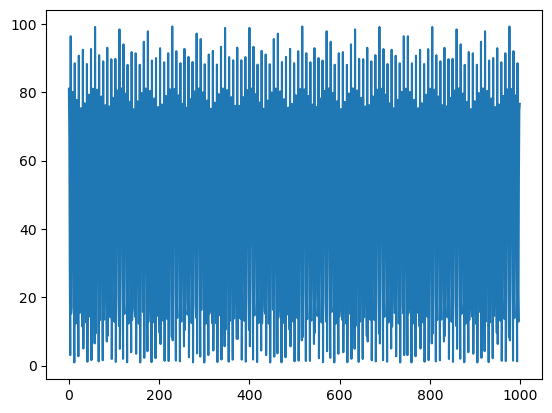

In [28]:
plt.plot(loss_array)

In [29]:
print(a)

tensor([1.4638], requires_grad=True)
